In [72]:
using Plots; gr()
using Reproduce
using FileIO
using Statistics
using ProgressMeter
using DataStructures
# using JLD2
using RollingFunctions
data_home = "../working_results/final_runs_with_acc"

"../working_results/final_runs_with_acc"

In [3]:
tol_muted = parse.(Colorant, ("#88CCEE", "#44AA99", "#117733", "#332288", "#DDCC77", "#999933","#CC6677", "#882255", "#AA4499", "#DDDDDD"))

(RGB{N0f8}(0.533,0.8,0.933), RGB{N0f8}(0.267,0.667,0.6), RGB{N0f8}(0.067,0.467,0.2), RGB{N0f8}(0.2,0.133,0.533), RGB{N0f8}(0.867,0.8,0.467), RGB{N0f8}(0.6,0.6,0.2), RGB{N0f8}(0.8,0.4,0.467), RGB{N0f8}(0.533,0.133,0.333), RGB{N0f8}(0.667,0.267,0.6), RGB{N0f8}(0.867,0.867,0.867))

In [4]:
function get_setting(ic, clean_func)

    diff_dict = diff(ic)
    
    itms = ic.items
    res = zeros(length(ic.items))
    for (itm_idx, itm) ∈ enumerate(itms)
        try
            res[itm_idx] = clean_func(
                FileIO.load(joinpath(itm.folder_str, "results.jld2")))
            if isnan(res[itm_idx])
                res[itm_idx] = Inf
            end
        catch
            println("error: $(itm.folder_str)")
            res[itm_idx] = Inf
        end
    end
    μ = mean(res)
    if isinf(μ)
        μ = 10000
    end
    σ = std(res)./sqrt(length(itms))
    if isnan(σ)
        σ = 0
    end
    
    return μ, σ
end

function get_best_setting(ic, sweep_params, clean_comp_func, clean_ret_func)

    diff_dict = diff(ic)

    μ_comp = zeros(length(diff_dict[sweep_param]))
    μ_ret = []
    σ_ret = []
    
    for (swprm_idx, swprm) ∈ enumerate(Iterators.diff_dict[sweep_param])
        sub_ic = search(ic, Dict(sweep_param=>swprm))
        res = zeros(length(sub_ic.items))
        
        res_ret = []
        
        for (itm_idx, itm) ∈ enumerate(sub_ic.items)
            try
                d = FileIO.load(joinpath(itm.folder_str, "results.jld2"))
                res[itm_idx] = clean_comp_func(d)
                push!(res_ret, clean_ret_func(d))
                if isnan(res[itm_idx])
                    res[itm_idx] = Inf
                end
            catch
                println("error: $(itm.folder_str)")
                res[itm_idx] = Inf
            end
        end
        μ_comp[swprm_idx] = mean(res)
        push!(μ_ret, mean(res_ret))
        push!(σ_ret, std(res_ret)./sqrt(length(sub_ic.items)))
    end
    min_idx = findmin(μ_comp)
    diff_dict[sweep_param][min_idx[2]], (μ_ret[min_idx[2]], σ_ret[min_idx[2]])
end

get_best_setting (generic function with 1 method)

# RingWorld

In [6]:
function plot_trunc_ring_world(ic, lp; clean_func=(d)->d["results"]["end"], lp_sub_set = nothing, line_settings=nothing, plt=nothing, kwargs...)
    diff_dict = diff(ic)
#     plt = nothing
    
    if line_settings == nothing
        line_settings = Dict{typeof(diff_dict[lp][1]), Any}()
        for lp_set ∈ diff_dict[lp]
            line_settings[lp_set] = Dict{Symbol, Any}(
                :label => lp_set
            )
        end
    end
    
    for horde ∈ (lp_sub_set == nothing ? diff_dict[lp] : lp_sub_set)
        sub_ic = search(ic, Dict(lp=>horde))
        μ = zeros(length(diff(sub_ic)["truncation"]))
        σ = zeros(length(diff(sub_ic)["truncation"]))
        for (idx, trunc) ∈ enumerate(diff(sub_ic)["truncation"])
            μ[idx], σ[idx] = get_setting(search(sub_ic, Dict("truncation"=>trunc)), clean_func)
        end
        if plt == nothing
            plt = plot(diff(sub_ic)["truncation"], μ, yerr=σ; label=horde, line_settings[horde]..., kwargs...)
        else
            plot!(plt, diff(sub_ic)["truncation"], μ, yerr=σ; label=horde, line_settings[horde]..., kwargs...)
        end
    end
    plt
end

function plot_trunc_ring_world(ic_rnn, ic_gvfn, ic_forecast; kwargs...)
    plt = plot_trunc_comp_world(ic_gvfn, "horde"; lp_sub_set=("chain", "gamma_chain", "gammas_term"), kwargs...)
    plot_trunc_comp_world(ic_rnn, "cell"; plt=plt, kwargs...)
    return plt
end

plot_trunc_ring_world (generic function with 2 methods)

In [7]:
function plot_lc_ring_world(ic, lp::String; clean_func=(d)->d["results"]["lc"], lp_sub_set = nothing, line_settings=nothing, plt=nothing, kwargs...)
    diff_dict = diff(ic)
#     plt = nothing
    
    if line_settings == nothing
        line_settings = Dict{typeof(diff_dict[lp][1]), Any}()
        for lp_set ∈ diff_dict[lp]
            line_settings[lp_set] = Dict{Symbol, Any}(
                :label => lp_set
            )
        end
    end

    for horde ∈ (lp_sub_set == nothing ? diff_dict[lp] : lp_sub_set)
        sub_ic = search(ic, Dict(lp=>horde))
        res = []
#         println(length(sub_ic.items))
        for itm ∈ sub_ic.items
            push!(res, clean_func(FileIO.load(joinpath(itm.folder_str, "results.jld2"))))
        end
        line = mean(res)
        line_σ = std(res) ./ sqrt(length(res))
        if plt == nothing
            plt = plot(line, ribbon=line_σ; label=horde, line_settings[horde]..., kwargs...)
        else
            plot!(plt, line, ribbon=line_σ; label=horde, line_settings[horde]..., kwargs...)
        end
    end
    plt
end


function plot_lc_ring_world(ic_gvfn_rw, ic_rnn_rw, ic_fore_rw=nothing; line_settings=nothing, kwargs...)
    plt = plot_lc_ring_world(ic_gvfn_rw, "horde"; line_settings=line_settings, kwargs...)
    plot_lc_ring_world(ic_rnn_rw, "cell"; line_settings=line_settings, plt=plt, kwargs...)
    plt
end

function plot_lc_trunc_ring_world_single(ic_gvfn_rw, ic_rnn_rw, ic_fore_rw=nothing, trunc=1; line_settings=nothing, kwargs...)
    plt = plot_lc_ring_world(search(ic_gvfn_rw, Dict("truncation"=>trunc)), "horde"; lp_sub_set=("chain", "gamma_chain", "gammas_term"), line_settings=line_settings, kwargs...)
    plot_lc_ring_world(search(ic_rnn_rw, Dict("truncation"=>trunc)), "cell"; line_settings=line_settings, plt=plt, kwargs...)
end

function plot_lc_trunc_ring_world(ic_gvfn_rw, ic_rnn_rw, ic_fore_rw=nothing; line_settings=nothing, kwargs...)
    plts = []
    for trunc ∈ diff(ic_gvfn_rw)["truncation"]
        plt = plot_lc_ring_world(search(ic_gvfn_rw, Dict("truncation"=>trunc)), "horde"; line_settings=line_settings, title="Truncation: $(trunc)", kwargs...)
        plot_lc_ring_world(search(ic_rnn_rw, Dict("truncation"=>trunc)), "cell"; line_settings=line_settings, plt=plt, kwargs...)
        push!(plts, plt)
    end
    plot(plts..., size=(800,800))
end


plot_lc_trunc_ring_world (generic function with 2 methods)

In [17]:
ic_ringworld_gvfn = ItemCollection(joinpath(data_home, "final_ringworld_gvfn/data"));
ic_ringworld_rnn = ItemCollection(joinpath(data_home, "final_ringworld_rnn/data"));
ic_ringworld_forecast = ItemCollection(joinpath(data_home, "final_ringworld_forecast/data"));

In [59]:
line_settings = Dict(
    "chain"=>Dict(:color=>tol_muted[1]),
    "gammas_aj"=>Dict(:color=>tol_muted[7]),
    "gammas_aj_term"=>Dict(:color=>tol_muted[8]),
    "gammas_term"=>Dict(:color=>tol_muted[9]),
    "gamma_chain"=>Dict(:color=>tol_muted[4]),
    "ARNN"=>Dict(:color=>tol_muted[3]),
    "LSTM"=>Dict(:color=>tol_muted[5]),
    "GRU"=>Dict(:color=>tol_muted[6])
)
plot_settings = Dict(
    :tickdir=>:out, 
    :grid=>false, 
    :lw=>3, 
    :legend=>false, 
    :minorticks=>2, 
    :tickfont => font(14, "TimesNewRoman"),
#     :xlabel=>"Truncation",
#     :guidefont=> font(16, "TimesNewRoman")
#     :xlabelfont=> font(16, "TimesNewRoman")
)
ic_ringworld_gvfn_6_onestep = search(ic_ringworld_gvfn, Dict("size"=>6, "outhorde"=>"onestep"))
ic_ringworld_rnn_6_onestep = search(ic_ringworld_rnn, Dict("size"=>6, "outhorde"=>"onestep"))
plot_trunc_ring_world(ic_ringworld_rnn_6_onestep, ic_ringworld_gvfn_6_onestep, nothing; clean_func=(d)->d["results"]["end"], line_settings=line_settings, plot_settings...)
savefig("ringworld_descent_sans_aj.pdf")

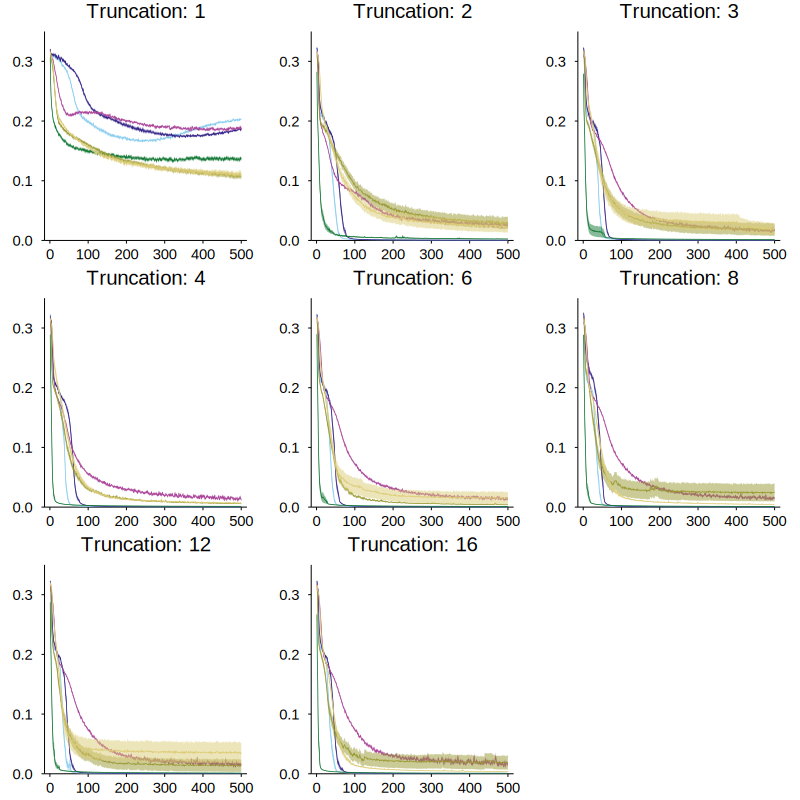

In [63]:
line_settings = Dict(
    "chain"=>Dict(:color=>tol_muted[1]),
    "gammas_aj"=>Dict(:color=>tol_muted[7]),
    "gammas_aj_term"=>Dict(:color=>tol_muted[8]),
    "gammas_term"=>Dict(:color=>tol_muted[9]),
    "gamma_chain"=>Dict(:color=>tol_muted[4]),
    "ARNN"=>Dict(:color=>tol_muted[3]),
    "LSTM"=>Dict(:color=>tol_muted[5]),
    "GRU"=>Dict(:color=>tol_muted[6])
)
plot_settings = Dict(
    :tickdir=>:out, 
    :grid=>false, 
    :lw=>0.8, 
    :legend=>false,
    :tickdir=>:out,
#     :minorticks=>2, 
    :titlefont=> font(14, "TimesNewRoman"),
    :tickfont => font(10, "TimesNewRoman"))
ic_ringworld_gvfn_6_onestep = search(ic_ringworld_gvfn, Dict("size"=>6, "outhorde"=>"onestep"))
ic_ringworld_rnn_6_onestep = search(ic_ringworld_rnn, Dict("size"=>6, "outhorde"=>"onestep"))
plot_lc_trunc_ring_world(ic_ringworld_gvfn_6_onestep, ic_ringworld_rnn_6_onestep, nothing; line_settings=line_settings, ylim=(0.0, 0.35), plot_settings...)
# savefig("ringworld_6_onestep_lc.pdf")

In [67]:
line_settings = Dict(
    "chain"=>Dict(:color=>tol_muted[1]),
    "gammas_aj"=>Dict(:color=>tol_muted[7]),
    "gammas_aj_term"=>Dict(:color=>tol_muted[8]),
    "gammas_term"=>Dict(:color=>tol_muted[9]),
    "gamma_chain"=>Dict(:color=>tol_muted[4]),
    "ARNN"=>Dict(:color=>tol_muted[3]),
    "LSTM"=>Dict(:color=>tol_muted[5]),
    "GRU"=>Dict(:color=>tol_muted[6])
)
plot_settings = Dict(
    :tickdir=>:out, 
    :grid=>false, 
    :lw=>3, 
    :legend=>false,
    :tickdir=>:out,
#     :minorticks=>2, 
    :titlefont=> font(14, "TimesNewRoman"),
    :tickfont => font(14, "TimesNewRoman"))
ic_ringworld_gvfn_6_onestep = search(ic_ringworld_gvfn, Dict("size"=>6, "outhorde"=>"onestep"))
ic_ringworld_rnn_6_onestep = search(ic_ringworld_rnn, Dict("size"=>6, "outhorde"=>"onestep"))
plot_lc_trunc_ring_world_single(ic_ringworld_gvfn_6_onestep, ic_ringworld_rnn_6_onestep, nothing, 2; line_settings=line_settings, ylim=(0.0, 0.35), plot_settings...)
savefig("ringworld_6_onestep_lc_trunc_2_sans_aj.pdf")

In [19]:
ic_ringworld_gvfn_adam = ItemCollection(joinpath(data_home, "final_ringworld_gvfn_adam/data"));
ic_ringworld_rnn_adam = ItemCollection(joinpath(data_home, "final_ringworld_rnn_adam/data"));
ic_ringworld_forecast_adam = ItemCollection(joinpath(data_home, "final_ringworld_forecast_adam/data"));

In [73]:
line_settings = Dict(
    "chain"=>Dict(:color=>tol_muted[1]),
    "gammas_aj"=>Dict(:color=>tol_muted[7]),
    "gammas_aj_term"=>Dict(:color=>tol_muted[8]),
    "gammas_term"=>Dict(:color=>tol_muted[9]),
    "gamma_chain"=>Dict(:color=>tol_muted[4]),
    "ARNN"=>Dict(:color=>tol_muted[3]),
    "LSTM"=>Dict(:color=>tol_muted[5]),
    "GRU"=>Dict(:color=>tol_muted[6])
)
plot_settings = Dict(
    :tickdir=>:out, 
    :grid=>false, 
    :lw=>3, 
    :legend=>false, 
    :minorticks=>2, 
    :tickfont => font(14, "TimesNewRoman"),
#     :xlabel=>"Truncation",
#     :guidefont=> font(16, "TimesNewRoman")
#     :xlabelfont=> font(16, "TimesNewRoman")
)
ic_ringworld_gvfn_adam_6_onestep = search(ic_ringworld_gvfn_adam, Dict("size"=>6, "outhorde"=>"onestep"))
ic_ringworld_rnn_adam_6_onestep = search(ic_ringworld_rnn_adam, Dict("size"=>6, "outhorde"=>"onestep"))
plot_trunc_ring_world(ic_ringworld_rnn_adam_6_onestep, ic_ringworld_gvfn_adam_6_onestep, nothing; clean_func=(d)->d["results"]["end"], line_settings=line_settings, plot_settings...)
savefig("ringworld_adam_sans_aj.pdf")

In [70]:
line_settings = Dict(
    "chain"=>Dict(:color=>tol_muted[1]),
    "gammas_aj"=>Dict(:color=>tol_muted[7]),
    "gammas_aj_term"=>Dict(:color=>tol_muted[8]),
    "gammas_term"=>Dict(:color=>tol_muted[9]),
    "gamma_chain"=>Dict(:color=>tol_muted[4]),
    "ARNN"=>Dict(:color=>tol_muted[3]),
    "LSTM"=>Dict(:color=>tol_muted[5]),
    "GRU"=>Dict(:color=>tol_muted[6])
)
plot_settings = Dict(
    :tickdir=>:out, 
    :grid=>false, 
    :lw=>3, 
    :legend=>false,
    :tickdir=>:out,
#     :minorticks=>2, 
    :titlefont=> font(14, "TimesNewRoman"),
    :tickfont => font(14, "TimesNewRoman"))
ic_ringworld_gvfn_adam_6_onestep = search(ic_ringworld_gvfn_adam, Dict("size"=>6, "outhorde"=>"onestep"))
ic_ringworld_rnn_adam_6_onestep = search(ic_ringworld_rnn_adam, Dict("size"=>6, "outhorde"=>"onestep"))
plot_lc_trunc_ring_world_single(ic_ringworld_gvfn_adam_6_onestep, ic_ringworld_rnn_adam_6_onestep, nothing, 2; line_settings=line_settings, ylim=(0.0, 0.35), plot_settings...)
savefig("ringworld_adam_6_onestep_lc_truc_2_sans_aj.pdf")

In [123]:
ic_ringworld_gvfn = ItemCollection(joinpath(data_home, "final_ringworld_gvfn/data"));

In [124]:
length(ic_ringworld_gvfn)

4800

In [290]:
diff(ic_ringworld_gvfn)["horde"]

5-element Array{String,1}:
 "chain"         
 "gamma_chain"   
 "gammas_aj"     
 "gammas_aj_term"
 "gammas_term"   

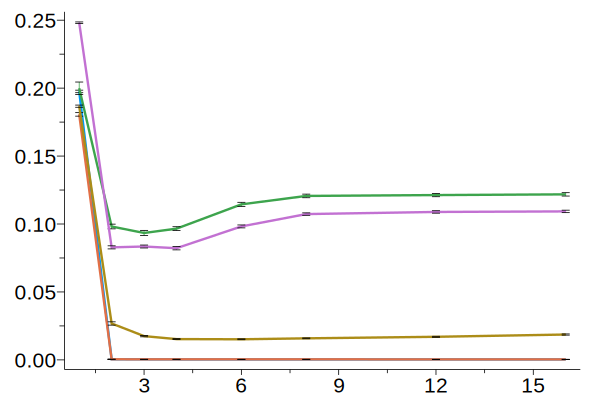

In [289]:
ic_ringworld_gvfn_6_onestep = search(ic_ringworld_gvfn, Dict("size"=>6, "outhorde"=>"onestep"))
plot_trunc_ring_world(ic_ringworld_gvfn_6_onestep, "horde"; plot_settings...)

In [127]:
ic_ringworld_rnn = ItemCollection(joinpath(data_home, "final_ringworld_rnn/data"));

In [128]:
length(ic_ringworld_rnn)

2880

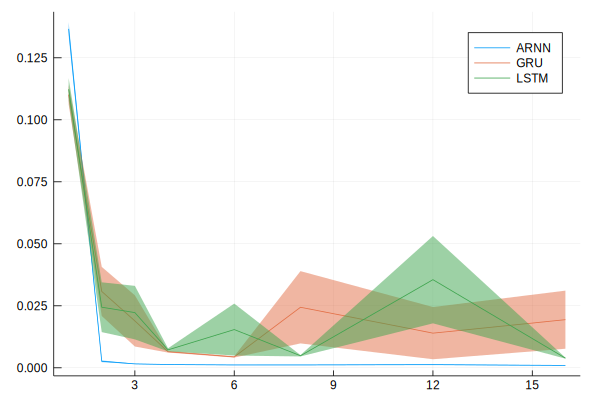

In [129]:
begin
#     clean_func=(d)->mean(d["results"]["lc"][241:300])
    clean_func=(d)->d["results"]["end"]
    ring_size = 6; outhorde="onestep"
    diff_dict = diff(ic_ringworld_rnn)
    plt = nothing
    for cell ∈ diff_dict["cell"]
        sub_ic = search(ic_ringworld_rnn, Dict("size"=>ring_size, 
                                                "outhorde"=>outhorde, 
                                                "cell"=>cell))
        μ = zeros(length(diff(sub_ic)["truncation"]))
        σ = zeros(length(diff(sub_ic)["truncation"]))
        for (idx, trunc) ∈ enumerate(diff(sub_ic)["truncation"])
            μ[idx], σ[idx] = get_setting(search(sub_ic, Dict("truncation"=>trunc)), clean_func)
        end
        if plt == nothing
            plt = plot(diff(sub_ic)["truncation"], μ, ribbon=σ, label=cell)
        else
            plot!(plt, diff(sub_ic)["truncation"], μ, ribbon=σ, label=cell)
        end
    end
    plt
end

In [130]:
ic_ringworld_gvfn_adam = ItemCollection(joinpath(data_home, "final_ringworld_gvfn_adam/data"));

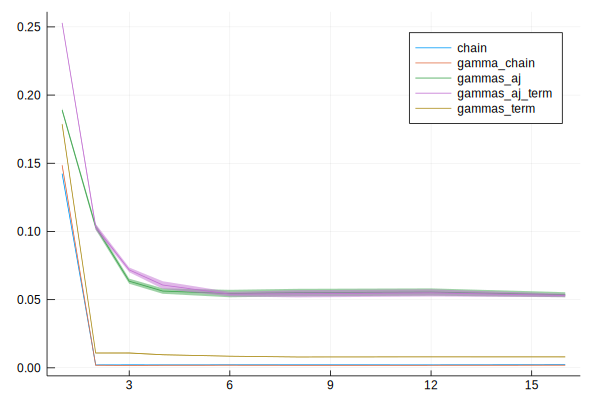

In [131]:
begin
    clean_func=(d)->d["results"]["end"]
    ring_size = 6; outhorde="onestep"
    diff_dict = diff(ic_ringworld_gvfn_adam)
    plt = nothing
    for horde ∈ diff_dict["horde"]
        sub_ic = search(ic_ringworld_gvfn_adam, Dict("size"=>ring_size, 
                                                    "outhorde"=>outhorde, 
                                                    "horde"=>horde))
        μ = zeros(length(diff(sub_ic)["truncation"]))
        σ = zeros(length(diff(sub_ic)["truncation"]))
        for (idx, trunc) ∈ enumerate(diff(sub_ic)["truncation"])
            μ[idx], σ[idx] = get_setting(search(sub_ic, Dict("truncation"=>trunc)), clean_func)
        end
        if plt == nothing
            plt = plot(diff(sub_ic)["truncation"], μ, ribbon=σ, label=horde)
        else
            plot!(plt, diff(sub_ic)["truncation"], μ, ribbon=σ, label=horde)
        end
    end
    plt
end

In [132]:
ic_ringworld_rnn_adam = ItemCollection(joinpath(data_home, "final_ringworld_rnn_adam/data"));

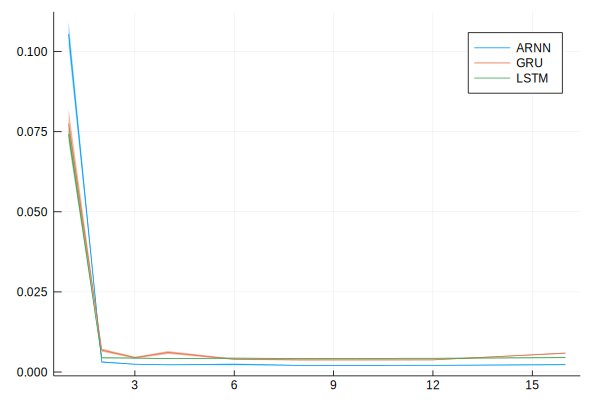

In [133]:
begin
    clean_func=(d)->d["results"]["end"]
    ring_size = 6; outhorde="onestep"
    diff_dict = diff(ic_ringworld_rnn_adam)
    plt = nothing
    for cell ∈ diff_dict["cell"]
        sub_ic = search(ic_ringworld_rnn_adam, Dict("size"=>ring_size, 
                                                    "outhorde"=>outhorde, 
                                                    "cell"=>cell))
        μ = zeros(length(diff(sub_ic)["truncation"]))
        σ = zeros(length(diff(sub_ic)["truncation"]))
        for (idx, trunc) ∈ enumerate(diff(sub_ic)["truncation"])
            μ[idx], σ[idx] = get_setting(search(sub_ic, Dict("truncation"=>trunc)), clean_func)
        end
        if plt == nothing
            plt = plot(diff(sub_ic)["truncation"], μ, ribbon=σ, label=cell)
        else
            plot!(plt, diff(sub_ic)["truncation"], μ, ribbon=σ, label=cell)
        end
    end
    plt
end

# Compass World

In [5]:
function plot_trunc_comp_world(ic, lp; clean_func=(d)->d["results"]["end"], lp_sub_set = nothing, line_settings=nothing, plt=nothing, kwargs...)
    diff_dict = diff(ic)
#     plt = nothing
    
    if line_settings == nothing
        line_settings = Dict{typeof(diff_dict[lp][1]), Any}()
        for lp_set ∈ diff_dict[lp]
            line_settings[lp_set] = Dict{Symbol, Any}(
                :label => lp_set
            )
        end
    end
    
    for horde ∈ (lp_sub_set == nothing ? diff_dict[lp] : lp_sub_set)
        sub_ic = search(ic, Dict(lp=>horde))
        μ = zeros(length(diff(sub_ic)["truncation"]))
        σ = zeros(length(diff(sub_ic)["truncation"]))
        for (idx, trunc) ∈ enumerate(diff(sub_ic)["truncation"])
            μ[idx], σ[idx] = get_setting(search(sub_ic, Dict("truncation"=>trunc)), clean_func)
        end
        if plt == nothing
            plt = plot(diff(sub_ic)["truncation"], μ, yerr=σ; label=horde, line_settings[horde]..., kwargs...)
        else
            plot!(plt, diff(sub_ic)["truncation"], μ, yerr=σ; label=horde, line_settings[horde]..., kwargs...)
        end
    end
    plt
end

function plot_trunc_comp_world(ic_rnn, ic_gvfn, ic_forecast; kwargs...)
    plt = plot_trunc_comp_world(ic_gvfn, "gvfn-horde"; kwargs...)
    plot_trunc_comp_world(ic_rnn, "cell"; plt=plt, kwargs...)
    plot_trunc_comp_world(ic_forecast, "cell"; lp_sub_set=["ARNNCell"], plt=plt, kwargs...)
    return plt
end

plot_trunc_comp_world (generic function with 2 methods)

In [67]:
function plot_lc_comp_world(ic, lp::String; clean_func=(d)->d["results"]["lc"][1,:], lp_sub_set = nothing, line_settings=nothing, plt=nothing, kwargs...)
    diff_dict = diff(ic)
#     plt = nothing
    
    if line_settings == nothing
        line_settings = Dict{typeof(diff_dict[lp][1]), Any}()
        for lp_set ∈ diff_dict[lp]
            line_settings[lp_set] = Dict{Symbol, Any}(
                :label => lp_set
            )
        end
    end

    for horde ∈ (lp_sub_set == nothing ? diff_dict[lp] : lp_sub_set)
        sub_ic = search(ic, Dict(lp=>horde))
        res = []
#         println(length(sub_ic.items))
        for itm ∈ sub_ic.items
            push!(res, clean_func(FileIO.load(joinpath(itm.folder_str, "results.jld2"))))
        end
        line = mean(res)
#         @show size(line)
        line_σ = std(res) ./ sqrt(length(res))
        if plt == nothing
            plt = plot(line, ribbon=line_σ; label=horde, line_settings[horde]..., kwargs...)
        else
            plot!(plt, line, ribbon=line_σ; label=horde, line_settings[horde]..., kwargs...)
        end
    end
    plt
end

function plot_lc_single_trunc(ic_gvfn_rw, ic_rnn_rw, ic_fore_rw=nothing, trunc=1; line_settings=nothing, kwargs...)
    plt = plot_lc_comp_world(search(ic_gvfn_rw, Dict("truncation"=>trunc)), "gvfn-horde"; line_settings=line_settings, kwargs...)
    plot_lc_comp_world(search(ic_rnn_rw, Dict("truncation"=>trunc)), "cell"; line_settings=line_settings, plt=plt, kwargs...)
    plot_lc_comp_world(search(ic_fore_rw, Dict("truncation"=>trunc)), "cell"; lp_sub_set=["ARNNCell"], line_settings=line_settings, plt=plt, kwargs...) 
    plt
end

function plot_legend(line_settings)
    plt = plot(ticks=nothing, border=:none)
    for k in keys(line_settings)
        plot!(plt, rand(1); line_settings[k]...)
    end
    plt
end

function plot_lc_trunc_comp_world(ic_gvfn_rw, ic_rnn_rw, ic_fore_rw=nothing; seperate_legend=false, line_settings=nothing, kwargs...)
    plts = []
    for trunc ∈ diff(ic_gvfn_rw)["truncation"]
        plt = plot_lc_comp_world(search(ic_gvfn_rw, Dict("truncation"=>trunc)), "gvfn-horde"; line_settings=line_settings, title="Truncation: $(trunc)", kwargs...)
        plot_lc_comp_world(search(ic_rnn_rw, Dict("truncation"=>trunc)), "cell"; line_settings=line_settings, plt=plt, kwargs...)
        plot_lc_comp_world(search(ic_fore_rw, Dict("truncation"=>trunc)), "cell"; line_settings=line_settings, plt=plt, kwargs...) 
        push!(plts, plt)
    end
    if seperate_legend
        plt = plot_legend(line_settings)
        push!(plts,plt)
    end
    
    plot(plts..., size=(800,800))
end

plot_lc_trunc_comp_world (generic function with 2 methods)

In [7]:
plot_settings = Dict(
    :tickdir=>:out, 
    :grid=>false, 
    :lw=>3, 
    :legend=>false, 
    :minorticks=>2, 
    :tickfont => font(14, "TimesNewRoman"),
#     :xlabel=>"Truncation",
#     :guidefont=> font(16, "TimesNewRoman")
#     :xlabelfont=> font(16, "TimesNewRoman")
)

Dict{Symbol,Any} with 6 entries:
  :grid       => false
  :tickfont   => Font("TimesNewRoman", 14, :hcenter, :vcenter, 0.0, RGB{N0f8}(0…
  :legend     => false
  :tickdir    => :out
  :lw         => 3
  :minorticks => 2

In [8]:
ic_compassworld_rnn_adam = ItemCollection(joinpath(data_home, "final_compworld_rnn_adam/data"));
ic_compassworld_rnn_aux_task_adam = ItemCollection(joinpath(data_home, "final_compworld_rnn_aux_task_adam/data"));
ic_compassworld_gvfn_adam = ItemCollection(joinpath(data_home, "final_compworld_gvfn_adam/data"));
ic_compassworld_forecast_adam = ItemCollection(joinpath(data_home, "final_compworld_forecast_adam/data"));

In [10]:
ret = FileIO.load(joinpath(ic_compassworld_rnn_adam[1].folder_str, "results.jld2"))["results"]["acc"]

1×1000 Array{Float64,2}:
 0.313  0.511  0.485  0.539  0.544  …  0.99  0.994  0.992  0.995  0.996

In [205]:
plot_settings = Dict(
    :tickdir=>:out, 
    :grid=>false, 
    :lw=>3, 
    :legend=>false, 
    :minorticks=>2, 
    :tickfont => font(18, "TimesNewRoman"),
    :ylim=>(0.0, 0.35)
#     :xlabel=>"Truncation",
#     :guidefont=> font(16, "TimesNewRoman")
#     :xlabelfont=> font(16, "TimesNewRoman")
)


line_settings = Dict(
    "forward"=>Dict(:color=>tol_muted[1]),
    "gammas_aj"=>Dict(:color=>tol_muted[7]),
    "gammas_aj_term"=>Dict(:color=>tol_muted[8]),
    "rafols"=>Dict(:color=>tol_muted[4]),
    "ARNN"=>Dict(:color=>tol_muted[3]),
    "ARNNCell"=>Dict(:color=>tol_muted[3], :ls=>:dash),
    "LSTM"=>Dict(:color=>tol_muted[5]),
    "LSTMCell"=>Dict(:color=>tol_muted[5], :ls=>:dash),
    "GRU"=>Dict(:color=>tol_muted[6]),
    "GRUCell"=>Dict(:color=>tol_muted[6], :ls=>:dash)
)

plot_trunc_comp_world(ic_compassworld_rnn_adam, ic_compassworld_gvfn_adam, ic_compassworld_forecast_adam; clean_func=(d)->d["results"]["end"], line_settings=line_settings, plot_settings...)
savefig("compassworld_adam_farnn.pdf")
# plot_trunc_comp_world(ic_compassworld_rnn_adam, ic_compassworld_gvfn_adam, nothing)

In [77]:
line_settings = OrderedDict(
    "forward"=>Dict(:color=>tol_muted[1], :label=>"Naive"),
    "gammas_aj"=>Dict(:color=>tol_muted[7], :label=>"Horizon"),
    "gammas_aj_term"=>Dict(:color=>tol_muted[8], :label=>"Terminating Horizon"),
    "rafols"=>Dict(:color=>tol_muted[4], :label=>"Expert"),
    "ARNN"=>Dict(:color=>tol_muted[3], :label=>"ARNN"),
    "ARNNCell"=>Dict(:color=>tol_muted[3], :ls=>:dash, :label=>"Fore-ARNN"),
    "LSTM"=>Dict(:color=>tol_muted[5], :label=>"LSTM"),
    "LSTMCell"=>Dict(:color=>tol_muted[5], :ls=>:dash, :label=>"Fore-LSTM"),
    "GRU"=>Dict(:color=>tol_muted[6], :label=>"GRU"),
    "GRUCell"=>Dict(:color=>tol_muted[6], :ls=>:dash, :label=>"Fore-GRU")
)
plot_settings = Dict(
    :tickdir=>:out, 
    :grid=>false, 
    :lw=>1.0, 
    :legend=>false, 
    :tickdir=>:out,
    :xlabel => "Steps (10^4)",
    :ylabel => "RMSVE",
#     :margin => 5Plots.mm,
    :titlefont=> font(14, "Times"),
    :tickfont => font(10, "Times"))
plot_lc_trunc_comp_world(ic_compassworld_gvfn_adam, ic_compassworld_rnn_adam, ic_compassworld_forecast_adam;seperate_legend=true, clean_func=(d)->mean(reshape(d["results"]["lc"][1,:], :, 100), dims=1)[1,:], line_settings=line_settings, plot_settings...)
savefig("compassworld_lc_adam.pdf")

In [202]:

plot_settings = Dict(
    :tickdir=>:out, 
    :grid=>false, 
    :lw=>2, 
    :legend=>false, 
    :tickdir=>:out,
#     :minorticks=>2, 
#     :ylim => (0.2, 1.0),
    :titlefont=> font(14, "TimesNewRoman"),
    :tickfont => font(18, "TimesNewRoman"))

line_settings = Dict(
    "forward"=>Dict(:color=>tol_muted[1]),
    "gammas_aj"=>Dict(:color=>tol_muted[7]),
    "gammas_aj_term"=>Dict(:color=>tol_muted[8]),
    "rafols"=>Dict(:color=>tol_muted[4]),
    "ARNN"=>Dict(:color=>tol_muted[3]),
    "ARNNCell"=>Dict(:color=>tol_muted[3], :ls=>:dash),
    "LSTM"=>Dict(:color=>tol_muted[5]),
    "LSTMCell"=>Dict(:color=>tol_muted[5], :ls=>:dash),
    "GRU"=>Dict(:color=>tol_muted[6]),
    "GRUCell"=>Dict(:color=>tol_muted[6], :ls=>:dash)
)

plot_lc_single_trunc(ic_compassworld_gvfn_adam, ic_compassworld_rnn_adam, ic_compassworld_forecast_adam, 8; clean_func=(d)->mean(reshape(d["results"]["acc"][1,:], :, 100), dims=1)[1,:], line_settings=line_settings, plot_settings...)
savefig("compworld_trunc_8_lc_acc_adam_smooth_farnn.pdf")

In [51]:
ic_compassworld_rnn = ItemCollection(joinpath(data_home, "final_compworld_rnn/data"));
ic_compassworld_rnn_aux_task = ItemCollection(joinpath(data_home, "final_compworld_rnn_aux_task/data"));
ic_compassworld_gvfn = ItemCollection(joinpath(data_home, "final_compworld_gvfn/data"));
ic_compassworld_forecast = ItemCollection(joinpath(data_home, "final_compworld_forecast/data"));

In [200]:
plot_settings = Dict(
    :tickdir=>:out, 
    :grid=>false, 
    :lw=>3, 
    :legend=>false, 
    :minorticks=>2, 
    :tickfont => font(18, "TimesNewRoman"),
    :ylim=>(0.0, 0.25)
#     :xlabel=>"Truncation",
#     :guidefont=> font(16, "TimesNewRoman")
#     :xlabelfont=> font(16, "TimesNewRoman")
)


line_settings = Dict(
    "forward"=>Dict(:color=>tol_muted[1]),
    "gammas_aj"=>Dict(:color=>tol_muted[7]),
    "gammas_aj_term"=>Dict(:color=>tol_muted[8]),
    "rafols"=>Dict(:color=>tol_muted[4]),
    "ARNN"=>Dict(:color=>tol_muted[3]),
    "ARNNCell"=>Dict(:color=>tol_muted[3], :ls=>:dash),
    "LSTM"=>Dict(:color=>tol_muted[5]),
    "LSTMCell"=>Dict(:color=>tol_muted[5], :ls=>:dash),
    "GRU"=>Dict(:color=>tol_muted[6]),
    "GRUCell"=>Dict(:color=>tol_muted[6], :ls=>:dash)
)

plot_trunc_comp_world(ic_compassworld_rnn, ic_compassworld_gvfn, ic_compassworld_forecast; clean_func=(d)->d["results"]["end"], legend=false, line_settings=line_settings, plot_settings...)
savefig("compassworld_descent_farnn.pdf")

In [76]:
line_settings = OrderedDict(
    "forward"=>Dict(:color=>tol_muted[1], :label=>"Naive"),
    "gammas_aj"=>Dict(:color=>tol_muted[7], :label=>"Horizon"),
    "gammas_aj_term"=>Dict(:color=>tol_muted[8], :label=>"Terminating Horizon"),
    "rafols"=>Dict(:color=>tol_muted[4], :label=>"Expert"),
    "ARNN"=>Dict(:color=>tol_muted[3], :label=>"ARNN"),
    "ARNNCell"=>Dict(:color=>tol_muted[3], :ls=>:dash, :label=>"Fore-ARNN"),
    "LSTM"=>Dict(:color=>tol_muted[5], :label=>"LSTM"),
    "LSTMCell"=>Dict(:color=>tol_muted[5], :ls=>:dash, :label=>"Fore-LSTM"),
    "GRU"=>Dict(:color=>tol_muted[6], :label=>"GRU"),
    "GRUCell"=>Dict(:color=>tol_muted[6], :ls=>:dash, :label=>"Fore-GRU")
)
plot_settings = Dict(
    :tickdir=>:out, 
    :grid=>false, 
    :lw=>1.0, 
    :legend=>false, 
    :tickdir=>:out,
    :xlabel => "Steps (10^4)",
    :ylabel => "RMSVE",
#     :margin => 5Plots.mm,
    :titlefont=> font(14, "Times"),
    :tickfont => font(10, "Times"))
plot_lc_trunc_comp_world(ic_compassworld_gvfn, ic_compassworld_rnn, ic_compassworld_forecast; seperate_legend=true, clean_func=(d)->mean(reshape(d["results"]["lc"][1,:], :, 100), dims=1)[1,:], line_settings=line_settings, legend=false, plot_settings...)
savefig("compassworld_lc.pdf")

In [208]:
plot_settings = Dict(
    :tickdir=>:out, 
    :grid=>false, 
    :lw=>2, 
    :legend=>false, 
    :tickdir=>:out,
#     :minorticks=>2, 
    :ylim => (0.3, 1.0),
    :titlefont=> font(14, "TimesNewRoman"),
    :tickfont => font(18, "TimesNewRoman"))

line_settings = Dict(
    "forward"=>Dict(:color=>tol_muted[1]),
    "gammas_aj"=>Dict(:color=>tol_muted[7]),
    "gammas_aj_term"=>Dict(:color=>tol_muted[8]),
    "rafols"=>Dict(:color=>tol_muted[4]),
    "ARNN"=>Dict(:color=>tol_muted[3]),
    "ARNNCell"=>Dict(:color=>RGBA(tol_muted[3], 0.9), :ls=>:dash),
    "LSTM"=>Dict(:color=>tol_muted[5]),
    "LSTMCell"=>Dict(:color=>RGBA(tol_muted[5], 0.9), :ls=>:dash),
    "GRU"=>Dict(:color=>tol_muted[6]),
    "GRUCell"=>Dict(:color=>RGBA(tol_muted[6], 0.9), :ls=>:dash)
)

plot_lc_single_trunc(ic_compassworld_gvfn, ic_compassworld_rnn, ic_compassworld_forecast, 8; clean_func=(d)->mean(reshape(d["results"]["acc"][1,:], :, 100), dims=1)[1,:], line_settings=line_settings, plot_settings...)
savefig("compworld_trunc_8_lc_acc_smooth_farnn.pdf")

In [211]:
diff(ic_compassworld_rnn_aux_task)

Dict{String,Array} with 5 entries:
  "at-horde"   => ["gammas_aj_term", "rafols"]
  "alpha"      => [0.0296296, 0.0444444, 0.0666667, 0.1, 0.15, 0.225, 0.3375]
  "truncation" => [1, 4, 8, 12, 16, 24, 32]
  "seed"       => [11, 12, 13, 14, 15, 16, 17, 18, 19, 20  …  31, 32, 33, 34, 3…
  "cell"       => ["ARNN", "GRU", "LSTM"]

In [223]:
diff(ic_compassworld_rnn_aux_task_adam)

Dict{String,Array} with 5 entries:
  "at-horde"   => ["gammas_aj_term", "rafols"]
  "alpha"      => [3.42549e-5, 0.000173415, 0.000390184]
  "truncation" => [1, 4, 8, 12, 16, 24, 32]
  "seed"       => [11, 12, 13, 14, 15, 16, 17, 18, 19, 20  …  31, 32, 33, 34, 3…
  "cell"       => ["ARNN", "GRU", "LSTM"]

In [247]:

plot_settings = Dict(
    :tickdir=>:out, 
    :grid=>false, 
    :lw=>3, 
    :legend=>false, 
    :minorticks=>2, 
    :tickfont => font(18, "TimesNewRoman"),
    :ylim=>(0.0, 0.25)
#     :xlabel=>"Truncation",
#     :guidefont=> font(16, "TimesNewRoman")
#     :xlabelfont=> font(16, "TimesNewRoman")
)


line_settings = Dict(
    "forward"=>Dict(:color=>tol_muted[1]),
    "gammas_aj"=>Dict(:color=>tol_muted[7]),
    "gammas_aj_term"=>Dict(:color=>tol_muted[8]),
    "rafols"=>Dict(:color=>tol_muted[4]),
    "ARNN"=>Dict(:color=>tol_muted[3]),
    "ARNNCell"=>Dict(:color=>tol_muted[3], :ls=>:dash),
    "LSTM"=>Dict(:color=>tol_muted[5]),
    "LSTMCell"=>Dict(:color=>tol_muted[5], :ls=>:dash),
    "GRU"=>Dict(:color=>tol_muted[6]),
    "GRUCell"=>Dict(:color=>tol_muted[6], :ls=>:dash)
)

plt = plot_trunc_comp_world(search(ic_compassworld_rnn_aux_task_adam, Dict("at-horde"=>"rafols")), "cell"; ls=:dash, clean_func=(d)->d["results"]["end"], legend=false, line_settings=line_settings, plot_settings...)
plot_trunc_comp_world(ic_compassworld_rnn_adam, "cell"; plt=plt, clean_func=(d)->d["results"]["end"], legend=false, line_settings=line_settings, plot_settings...)

savefig("compassworld_aux_task_rafols_adam.pdf")


In [134]:
ic_compassworld_gvfn_adam = ItemCollection(joinpath(data_home, "final_compworld_gvfn_adam/data"));

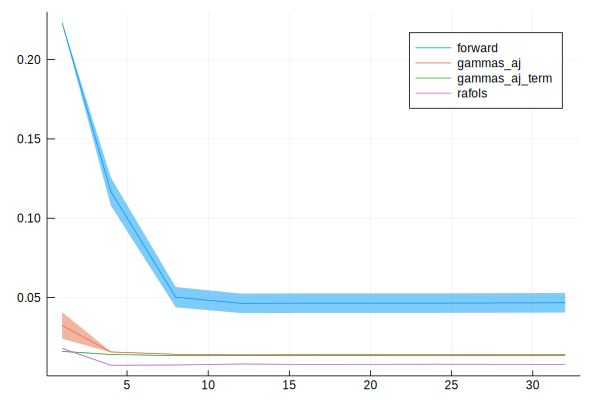

In [178]:
plot_trunc_comp_world(ic_compassworld_gvfn_adam, "gvfn-horde")

In [136]:
ic_compassworld_rnn_adam = ItemCollection(joinpath(data_home, "final_compworld_rnn_adam/data"));

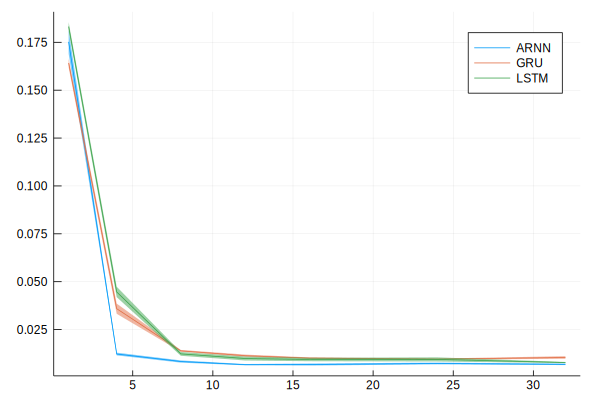

In [175]:
plot_trunc_comp_world(ic_compassworld_rnn_adam, "cell")

In [138]:
ic_compassworld_forecast_adam = ItemCollection(joinpath(data_home, "final_compworld_forecast_adam/data"));

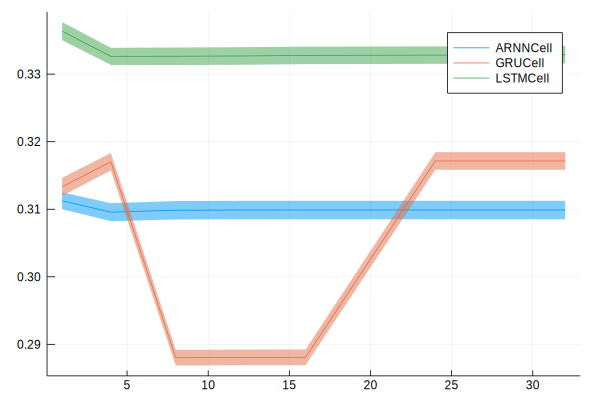

In [165]:
plot_trunc_comp_world(ic_compassworld_forecast_adam, "cell")

In [140]:
ic_compassworld_gvfn = ItemCollection(joinpath(data_home, "final_compworld_gvfn/data"));

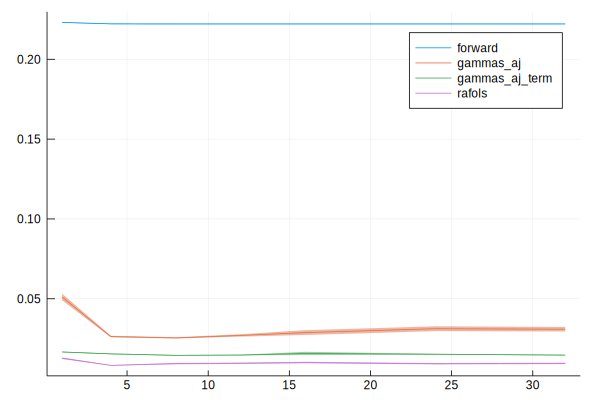

In [166]:
plot_trunc_comp_world(ic_compassworld_gvfn, "gvfn-horde")

In [142]:
ic_compassworld_rnn = ItemCollection(joinpath(data_home, "final_compworld_rnn/data"));

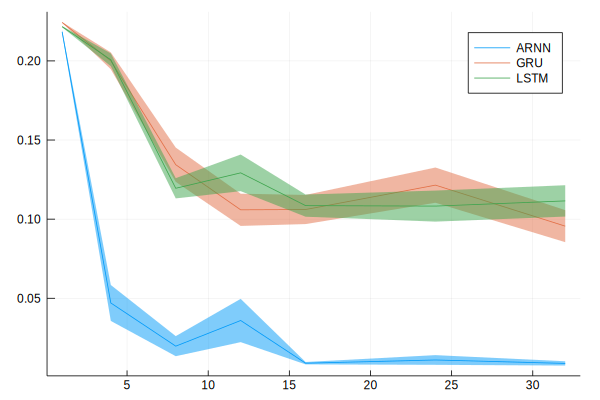

In [167]:
plot_trunc_comp_world(ic_compassworld_rnn, "cell")

In [144]:
ic_compassworld_forecast = ItemCollection(joinpath(data_home, "final_compworld_forecast/data"));

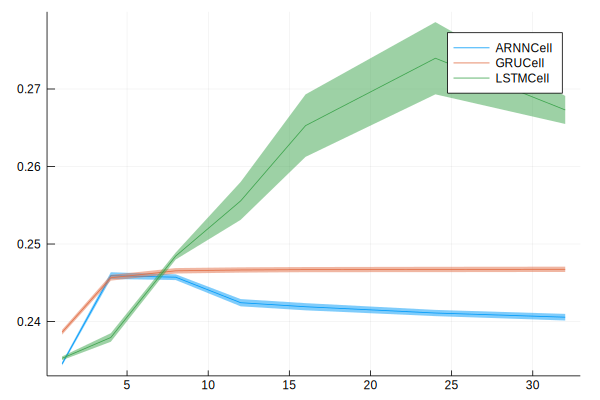

In [168]:
plot_trunc_comp_world(ic_compassworld_forecast, "cell")